# Analysis of the dataset: whale_shark

!pip install pycocotools

In [1]:
from pycocotools.coco import COCO
import numpy as np
import imageio as io
import matplotlib.pyplot as plt
import pylab
from utils import plot_names

%matplotlib inline

## Load annotations
This section is the same for all datasets. 

Update `dataDir` with the location of the data.

In [2]:
species = 'whaleshark_cropped' # 'whaleshark'
dataDir='/home/olga/Datasets/{}.coco'.format(species)
#dataDir = '/home/olga/projects/wbia-plugin-pie-v2/wbia_pie_v2/reid-data/{}/original/{}.coco'.format(species, species)
dataType= 'test2021' #'test2020' #'train2020'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [3]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


In [4]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms = [cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
rhincodon_typus whaleshark

COCO supercategories: 
animal


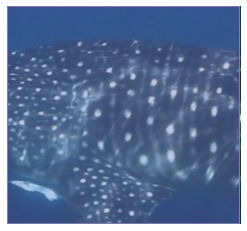

In [5]:
# load and display instance annotations
catIds = coco.getCatIds(catNms=nms);
imgIds = coco.getImgIds(catIds=catIds);

img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)
#anns

# Analyse names

Look at the distribution of images across unique names:

In [6]:
ann_ids = coco.getAnnIds()
all_anns = coco.loadAnns(coco.getAnnIds())

names_anns = np.array([coco.loadAnns(ann_id)[0]['name'] for ann_id in ann_ids])
uuids = np.array([coco.loadAnns(ann_id)[0]['uuid'] for ann_id in ann_ids])
unames, counts = np.unique(names_anns, return_counts=True)

print('Found {} annotations for {} names'.format(len(names_anns), len(unames)))

Found 7290 annotations for 548 names


Plot a histogram of unique names vs counts per name:

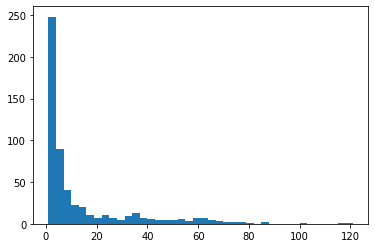

In [7]:
plt.hist(counts, bins=40)
plt.show()

In [8]:
for num in range(1, 11):
    print('{} individuals have {} image'.format((counts == num).sum(), num))

for low in range(10, 160, 10):
    high = low + 10
    print('{} individuals have >{} and <={} images'.
          format(np.logical_and((counts>low), 
                                (counts<=high)).sum(), 
                 low, 
                 high))

78 individuals have 1 image
109 individuals have 2 image
61 individuals have 3 image
40 individuals have 4 image
25 individuals have 5 image
24 individuals have 6 image
18 individuals have 7 image
10 individuals have 8 image
13 individuals have 9 image
6 individuals have 10 image
49 individuals have >10 and <=20 images
25 individuals have >20 and <=30 images
33 individuals have >30 and <=40 images
14 individuals have >40 and <=50 images
17 individuals have >50 and <=60 images
14 individuals have >60 and <=70 images
6 individuals have >70 and <=80 images
3 individuals have >80 and <=90 images
1 individuals have >90 and <=100 images
0 individuals have >100 and <=110 images
1 individuals have >110 and <=120 images
1 individuals have >120 and <=130 images
0 individuals have >130 and <=140 images
0 individuals have >140 and <=150 images
0 individuals have >150 and <=160 images


Get an array of filenames and bounding boxes for display purposes:

In [9]:
filenames = np.array([coco.loadImgs(ann['image_id'])[0]['file_name'] for ann in all_anns])
filenames = np.array(['%s/images/%s/%s'%(dataDir,dataType,f) for f in filenames])

bboxes = np.array([ann['segmentation_bbox'] for ann in all_anns])

Print images for a random name (new name is displayed every time the cell is executed):

Found 41 annots for name A-478


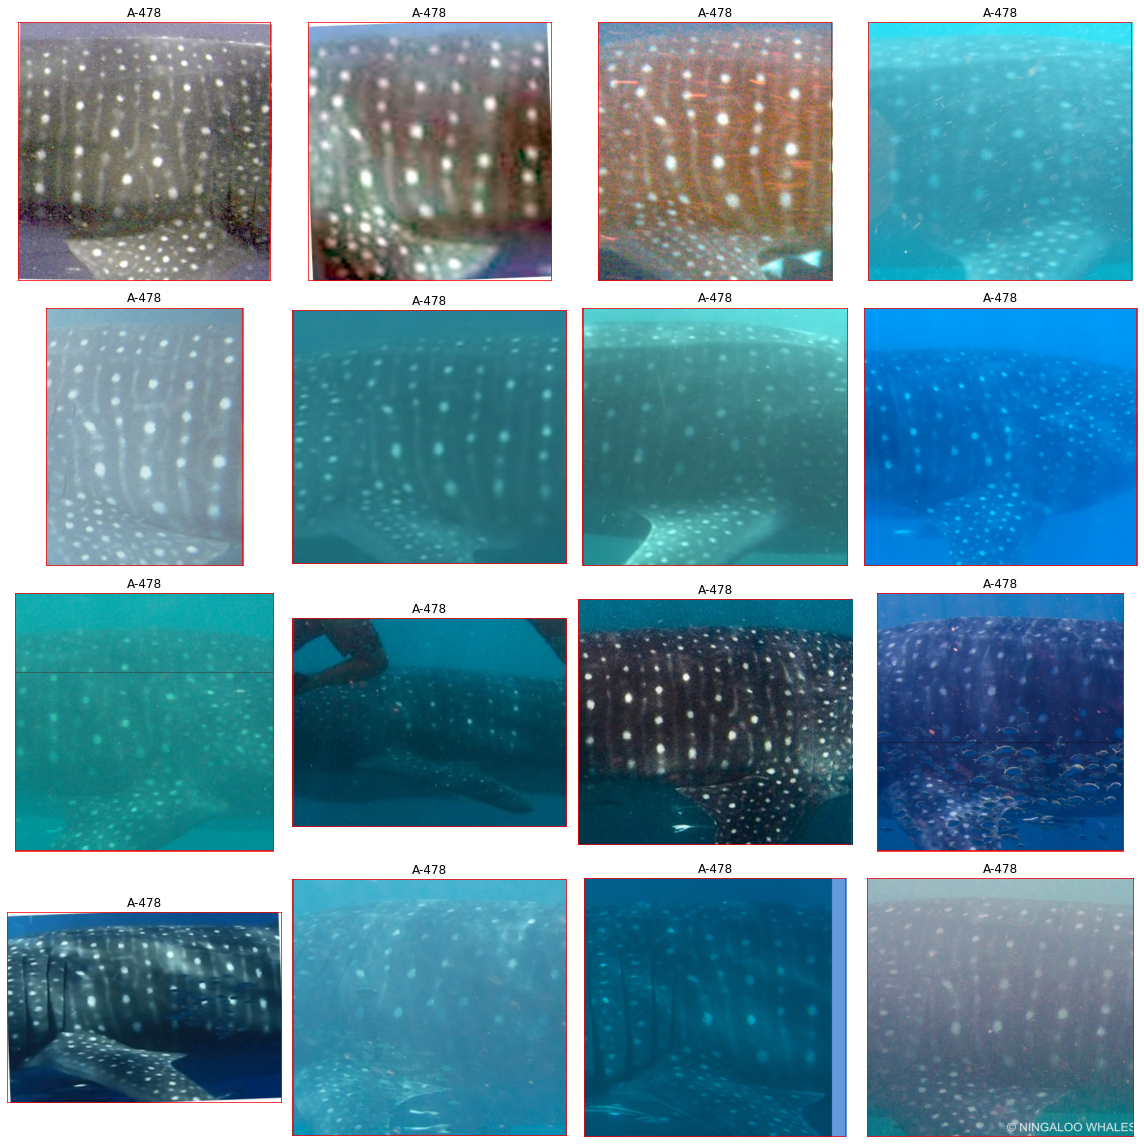

In [10]:
plot_names(names_anns, filenames, bboxes, names_anns, crop=False, max_display=16, ncols=4, ratio=(4,4))

# Analyse viewpoint annotations

Get view annotations from a separate json file:

In [1]:
view_annFile='{}/annotations/annotViewpointMap.csv'.format(dataDir,dataType)
uuid2view = np.genfromtxt(view_annFile, dtype=str, skip_header=1, delimiter=',')
print('Found {} view annotations'.format(len(uuid2view)))

NameError: name 'dataDir' is not defined

Make a dictionary to look up view annotation by uuid:

In [12]:
uuid2view = {a[0]: a[1] for a in uuid2view}

Map 'uuid' and 'view':

In [13]:
views = np.array([uuid2view[uuid] if uuid in uuid2view else 'none' for uuid in uuids])
views

array(['right', 'left', 'right', ..., 'right', 'left', 'right'],
      dtype='<U5')

There are some elements without view annotations. As the number of missing viewpoints is small, these annotations are discarded from the data.

In [14]:
(views == 'none').sum()

3

Combine view and name as a unique key for individual:

In [16]:
viewnames = np.array(['{}_{}'.format(name, view) for name, view in zip(names_anns, views)])

print('Found {} annotations for {} names'.format(len(viewnames), len(set(viewnames))))

Found 7290 annotations for 984 names


Plot a histogram of unique `name+viewpoint` vs `counts` per name:

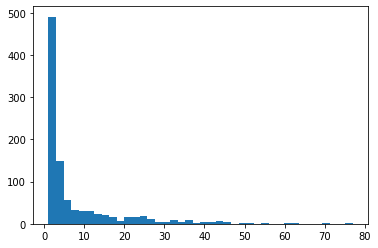

In [17]:
vunames, vcounts = np.unique(viewnames, return_counts=True)
plt.hist(vcounts, bins=40)
plt.show()

Found 46 annots for name A-013_right


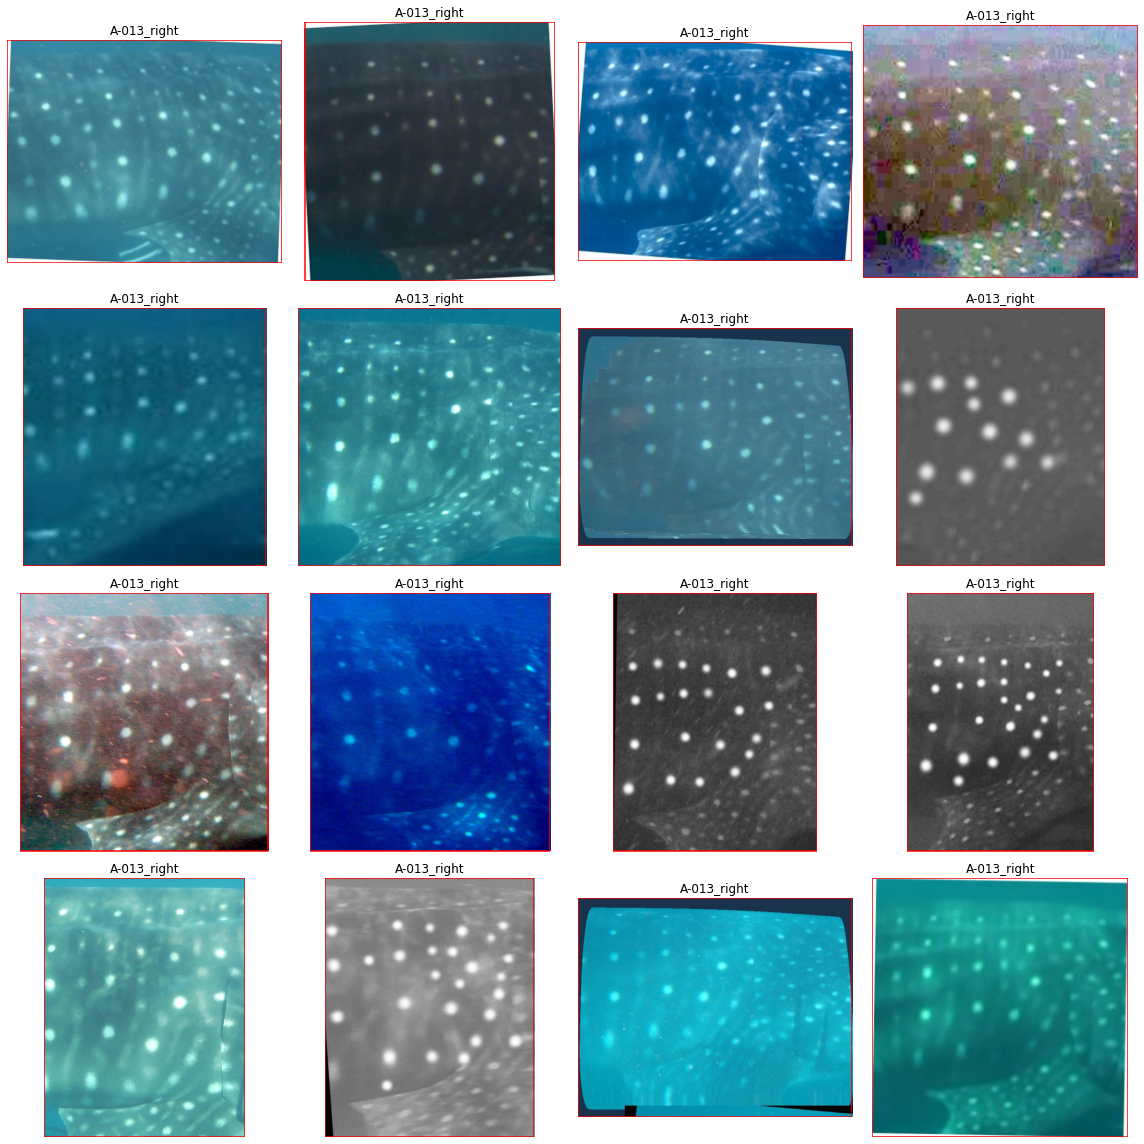

In [20]:
plot_names(viewnames, filenames, bboxes, viewnames, crop=False, max_display=16, ncols=4, ratio=(4,4))